In [2]:
using LinearAlgebra
using Plots
using LaTeXStrings
using DelimitedFiles
using Polynomials
using Statistics
fnt = Plots.font("sans-serif", 15) # Para gráficar loas labels


Plots.Font("sans-serif", 15, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,0.0))

In [3]:
#Nos busca un indice k tal que los numeros posteriores son 0
#k=3 si |2,1,0,0,0> 
function search_k(M::Int64,n::Vector{Int64})
    k=1 #iniciamos en la pos 1
    for i=1:M #Recorreremos todas las posisiciones M para checar las j>i
        k=i #Nuestro primer prospecto a ser j
        flag=0 #Definimos una bandera si es
                # 1--> significa que encontro una n_{j} tal que los de adelante son 0
                #0--> no lo ha encontrado
        for j=k+1:M-1 #Revisaremos los n_{j} j>i si son cero
            if n[j]!=0 # si encientra una n_{j}!=0
                break  # ya no revises más
            elseif (j == M-1) # si j llega al penultimo valor entonces
                flag=1 # ya lo encontró
            end
        end
        if flag==1 # si la bandera es 1, ya encontro la k
            k=i # entonces esa i es la k
            break # ya no hace falta revisar más
        end
    
    if k==M # si no encontro ningun valor entonces signfica que tomaremos el penultimo valor
        k=M-1
    end
        
    end
    
    return k
end

function base_fock(N::Int64,M::Int64)
    D=binomial(N+M-1,N) #declaramos la variable de la dimension del espacio de Hilbert
    DM=zeros(Int64,(D,M)) #Aquí se colocaran las bases
    n=zeros(Int64,M) #Este vector va a ser el que modificaremos y usaremos para sobre escribir cada fila de DM
    
    DM[1,1]=N #El primer estado de la base
    n[1]=N    # Coincidde con el estado base
    
    l=1 # es un contador para colocar los demas estados
     #k es el indice donde despues de ese todos son ceros
    
    while n[M]!=N
        l+=1 #incrementamos el contador
        k=search_k(M,n) #buscamos la k
        n[k]=n[k]-1 #Primer paso del cambio n_{k}=n_{k}-1
        #Compienza el segundo paso de la suma n_{k+1}=n_{k}-1
        n[k+1]=N

        for i=1:k
            n[k+1]=n[k+1]-n[i]
        end
        #Cambiamos por ceros los n_{i} tales que i>=k+2
        for i=k+2:M
            n[i]=0
        end
        #Agregamos el estado n a la fila l
        DM[l,:]=n
    end
    
    
    return DM;
    
end

# Operadores de Hamiltoniano
function ascenso_mu(mu::Int64, N::Int64,vector_base::Vector{Int64})
    part=vector_base[mu]+1
    norm=sqrt(vector_base[mu]+1)
    if part>N
        norm=0.0
    end
    vector_base[mu]=part
    return norm;
end

function descenso_mu(mu::Int64, N::Int64,vector_base::Vector{Int64})
    
    part=vector_base[mu]-1
    if vector_base[mu]<0
        norm=0.0
    else
        norm=sqrt(vector_base[mu])
    end
    
    if part<0
        norm=0.0
    end
    vector_base[mu]=part
    return norm;
end

function Numero_mu(mu::Int64, N::Int64,vector_base::Vector{Int64})
    return vector_base[mu];
end

##//Funcion para localizar vectores base//////////
function Buscador(vector_base::Vector{Int64},N::Int64,M::Int64)

    i0=N #indice para ayudarnos a que este fijo el num de particulas disponibles
    i1=0 #indice para ayudarnos a restar
    Sitios=2 #Numero de sitios que se quitan +1 (al principio se quita un sitio por eso es 2)

    contador=1

    for j=1:M
        while i0-i1 != vector_base[j]
            contador=contador+binomial(M-Sitios+i1,i1)
            i1+=1
        end
        i0=i1
        i1=0
        Sitios+=1
    end

    return contador
end

#Hamiltoniano Cinético at_{m}*a_{m+1} + at_{m+1}*a_{m}
function H_J(J::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    #Esta es la parte     at_{m}*a_{m+1} + at_{m+1}*a_{m}
    for l=1:D #Usaremos cada elemento de la base
        for mu=1:M #Recorreremos cada sitio del elemento de la base
            n=bases[l,:] #Es el vector con el que se trabajara
            #Aplicamos las condiciones de frontera periodicas ANILLO
            if mu==M
                a=descenso_mu(1,N,n)
                at=ascenso_mu(mu,N,n)
            else
                a=descenso_mu(mu+1,N,n)
                at=ascenso_mu(mu,N,n)
            end
            if at*a != 0
                col=Buscador(n,N,M)
                H[col,l]=H[col,l]-J*at*a
                H[l,col]=H[l,col]-J*at*a
            end

        end
    end
    return H
end



#Esta es la parte     at_{mu}*n_{mu+nu}*a_{m+1} + at_{mu+1}*n_{mu+nu}*a_{m}
function H_K1(K1::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    #Esta es la parte     at_{m}*a_{m+1} + at_{m+1}*a_{m}
    for l=1:D #Usaremos cada elemento de la base
        for mu=1:M #Recorreremos cada sitio del elemento de la base
            for nu=0:1 #esto es para el operador de numero n_{mu+nu}
                n=bases[l,:] #Es el vector con el que se trabajara
                #Aplicamos las condiciones de frontera periodicas ANILLO
                if mu==M && nu==1
                    a=descenso_mu(1,N,n)
                    num=Numero_mu(1,N,n)
                    at=ascenso_mu(mu,N,n)
                elseif mu==M && nu==0
                    a=descenso_mu(1,N,n)
                    num=Numero_mu(mu,N,n)
                    at=ascenso_mu(mu,N,n)
                else
                    a=descenso_mu(mu+1,N,n)
                    num=Numero_mu(mu+nu,N,n)
                    at=ascenso_mu(mu,N,n)
                end
                if at*a*num != 0
                    col=Buscador(n,N,M)
                    H[col,l]=H[col,l]-K1*at*a*num
                    H[l,col]=H[l,col]-K1*at*a*num
                end
            end
        end
    end
    return H
end


#Esta es la parte  at_{m}*at_{m}*a_{m+1}*a_{m+1} + at_{m+1}*at_{m+1}*a_{m}*a_{m}
function H_K2(K2::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    #Esta es la parte     at_{m}*a_{m+1} + at_{m+1}*a_{m}
    for l=1:D #Usaremos cada elemento de la base
        for mu=1:M #Recorreremos cada sitio del elemento de la base
            n=bases[l,:] #Es el vector con el que se trabajara
            #Aplicamos las condiciones de frontera periodicas ANILLO
            if mu==M
                a=descenso_mu(1,N,n)
                a=a*descenso_mu(1,N,n)
                at=ascenso_mu(mu,N,n)
                at=at*ascenso_mu(mu,N,n)
            else
                a=descenso_mu(mu+1,N,n)
                a=a*descenso_mu(mu+1,N,n)
                at=ascenso_mu(mu,N,n)
                at=at*ascenso_mu(mu,N,n)
            end

            if at*a != 0
                col=Buscador(n,N,M)
                H[col,l]=H[col,l]-K2*at*a
                H[l,col]=H[l,col]-K2*at*a
            end
        end
    end
    return H
end

#Esta es la parte  at_{m}*at_{m}*a_{m+1}*a_{m+1} + at_{m+1}*at_{m+1}*a_{m}*a_{m}
function H_U(U::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    for l=1:D #Usaremos cada elemento de la base
        n=bases[l,:] #Es el vector con el que se trabajara
        for i=1:M
            H[l,l]=H[l,l]+U*0.5*(n[i]*(n[i]-1))
        end
    end
    return H

end


#El hamiltoniano es H = H_J + H_K1 + H_K2 + H_U

# Change_E_F=eigvecs(H)
# #println(Change_E_F)
# Change_F_E=transpose(Change_E_F)
# # Condicion inicial, puede ser localizada
# Vector_0_F=[1,0,0,0,0,0] #Para este ejemplo ψ(0)=|1,0,1>
# # Hay que hacerel cambio de base antes de hacer la evolución temporal
# Vector_0_E=Change_F_E*Vector_0_F
# #println(Vector_0_E)
# #Para la evolcución temporal necesitamos los eigenvalores
# evals=eigvals(H)
# #println(evals)
# Este es el operador evolución temporal
#U_tempo(t)=exp.(-im*evals*t)

#Hay que hace una función con la condicion incial en E con evolución temporal U(t)
function Edo_evol_E(Vector_0, Evol_temp,D)
    Result=zeros(Complex{Float64},D)
    for i=1:D
        Result[i]=Vector_0[i]*Evol_temp[i]
    end
    return Result
end

# Edo_E_t=Edo_evol_E(Vector_0_E, U_tempo(1)) # Este es el vector estado inicial evolucionado en el tiempo en la base de E
# #println(Vector_0_E)
# #println(Edo_E_t)
# #Hay que pasarlo a la base de fock
# #Edo_F_t=Change_E_F*Edo_E_t
# Edo_F_t=Change_E_F*Edo_evol_E(Vector_0_E, U_tempo(1)) #<--- Aqui evoluciona el tiempo

# #HAcemos la matriz de densidad
# rho_c=Edo_F_t*transpose(conj(Edo_F_t))
#println(rho_c[1,:])
# de la teoria tenemos dos deltas de dirac que dicen que cosas viven y mueren 
#\delta_{n_{1}^{i}+n_{2}^{i}+...+n_{M}^{i}} , N} * \delta_{ n_{\nu}^{i}+n_{\mu}^{i} , n_{\nu}^{j}+n_{\mu}^{j} }

# para este ejemplo en particular 
#\delta_{n_{1}^{i}+n_{2}^{i}+n_{3}^{i}} , N} * \delta_{ n_{\nu}^{i}+n_{\mu}^{i} , n_{\nu}^{j}+n_{\mu}^{j} }

# Base extendida
function base_2_ex(N::Int64)
    base_2_extendida=zeros(Int64,((N+1)^2,2))
    l=1
    for i=0:N
        for j=0:N
            base_2_extendida[l,:]=[i,j]
            l=l+1
        end
    end
    return base_2_extendida
end

# base_2_extendida=base_2_ex(N)

function buscador_ext_bas(vector_base_ext::Vector{Int64},N::Int64)
    return ( vector_base_ext[1]*(N+1) )+1 +vector_base_ext[2]
end


# # tenemos que escoger con que los nos n_[\nu] y n_{\mu} para trazar sobre los otros.
# n_nu=1
# n_mu=3

#Matriz de densidad reducida
function rho_c_reducida_ex(n_nu::Int64,n_mu::Int64,N::Int64,M::Int64,D::Int64,
                                bases::Matrix{Int64},base_2_extendida::Matrix{Int64},rho_c::Matrix{ComplexF64},T=false)
   
    rho_c_reducida_exten=zeros(ComplexF64,((N+1)^2,(N+1)^2))

    ### Revisamos cada uno de los elemtnos de la base extendida |n_{\nu}^{i},n_{\mu}^{i}><n_{\nu}^{j},n_{\mu}^{j}|
    for i=1:(N+1)^2
        for j=1:(N+1)^2
            #### Esta es la primera delta de dirac (conservacion de particulas en la traza) --->
            ####  ---> \delta_{ n_{\nu}^{i}+n_{\mu}^{i} , n_{\nu}^{j}+n_{\mu}^{j} }
            if sum(base_2_extendida[i,:])==sum(base_2_extendida[j,:])
                #println(sum(base_2_extendida[i,:]), sum(base_2_extendida[j,:]))
                ### Aqui es la segunda delta de dirac (Conservacion de particulas sin traza) --->
                ### ----->\delta_{n_{1}^{i}+n_{2}^{i}+...+n_{M}^{i}} , N}
                for k=1:D #Tecnicamente ya sabemos quienes cumplen eso son los de la base de fock
                    # Reviamos que elementos de la base de fock tienen n_{\nu}^{i} y n_{\mu}^{i} simultaneamente de la base extendida para i
                    # el k-esimo elemento es <k|\rho(t)| NOSE >
                    if bases[k,:][n_nu]==base_2_extendida[i,1] && bases[k,:][n_mu]== base_2_extendida[i,2] 
                        #println(i," ",j," ",base_2_extendida[i,:], " ", base_2_extendida[j,:])
                        #falta construir el NOSE que se compone de |n_{}^{i}...n_{\nu}^{j}...n_{\mu}^{j}>
                        #Con el <k| coinciden los que no son n_{\nu}^{j} n_{\mu}^{j}, entonces
                        NOSE=bases[k,:]
                        NOSE[n_nu],NOSE[n_mu]=base_2_extendida[j,:][1],base_2_extendida[j,:][2]
                        #println(Buscador(bases[k,:],N,M), " ", Buscador(NOSE,N,M))
                        rho_c_reducida_exten[i,j]+=rho_c[Buscador(bases[k,:],N,M),Buscador(NOSE,N,M)]
                        #println("En en la entrada "*L"|",base_2_extendida[i,:],L"\rangle\langle",base_2_extendida[j,:],L"|"*"Entre!")
                    end

                end

            else
                #println(0)
            end

        end
    end
    
    if T==false
        return rho_c_reducida_exten #<----------------------Resultado
    else
        rho_c_reducida_exten_trans_par=zeros(ComplexF64,((N+1)^2,(N+1)^2))
        ## Vamos a recorer cada elemento de la matriz de densidad reducida para transponerla
        for i=1:(N+1)^2
                for j=1:(N+1)^2
                ### Trasnponemos |n_{\nu}^{i},n_{\mu}^{i}><n_{\nu}^{j},n_{\mu}^{j}| --->
                ###     ------>  |n_{\nu}^{i},n_{\mu}^{j}><n_{\nu}^{j},n_{\mu}^{i}|
                Transpo1=buscador_ext_bas( [base_2_extendida[i,:][1], base_2_extendida[j,:][2]] ,N)
                Transpo2=buscador_ext_bas( [base_2_extendida[j,:][1], base_2_extendida[i,:][2]] ,N)
                
                rho_c_reducida_exten_trans_par[Transpo1,Transpo2]=rho_c_reducida_exten[i,j]
                #println(i-1,",",j-1,"--->",Transpo1-1,",",Transpo2-1)
            end
        end
        return rho_c_reducida_exten_trans_par#<----------------------Resultado
    end
    
end

U_tempo(t,evals)=exp.(-im*evals*t)

U_tempo (generic function with 1 method)

In [6]:
##Parametros

Ni=[1]# Numero de Bosones
Mi=[6] ## Numero de sitios
    
for N in Ni
    for M in Mi
        
        #sitios de interes
        n_nu=1
        n_mu_i=[]
        if M==2 || M==3
            n_mu_i=[2]
        elseif M==4 || M==5
            n_mu_i=[2,3]
        elseif M==6
            n_mu_i=[2,3,4]
        end

        J=[0.01,0.05,0.1,0.25,0.5,1.0,2.5,5.0,10.0]
        U=1.0

        # #Sitios de interes
        # n_nu=1
        # n_mu=4

        #parametros temporales

        # tiempo
        dt=0.01
        Time_0=0
        Time_f=100
        times=Time_0:dt:Time_f
        #Times_i_f=[[0,10],[0,100],[50,100]]




        LOIC_in_sities=[]
        LOIC_out_sities=[]
        LOIC_two_regions=[]
        LOIC_ALL=[]
        Names_dir=[]
        LOICS=[]
        for n_mu in n_mu_i

            ######## UN BOSON (completo) #########
            if N==1 && M==2
                if n_nu==1 && n_mu==2
                    LOIC_ALL=[1 0]

                    Names_dir=["Adentro_Region"]
                    LOICS=[LOIC_ALL];
                end
            elseif N==1 && M==3
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[1 0 0]
                    LOIC_out_sities=[0 0 1]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities];
            elseif N==1 && M==4
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[1 0 0 0]
                    LOIC_out_sities=[0 0 0 1]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[0 1 0 0]
                    LOIC_out_sities=[1 0 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities];
            elseif N==1 && M==5
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[1 0 0 0 0]
                    LOIC_out_sities=[0 0 0 0 1; 0 0 0 1 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[1 0 0 0 0]
                    LOIC_out_sities=[0 1 0 0 0; 0 0 0 0 1]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities];
            elseif N==1 && M==6
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[1 0 0 0 0 0]
                    LOIC_out_sities=[0 0 0 0 0 1; 0 0 0 0 1 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[1 0 0 0 0 0]
                    LOIC_out_sities=[0 1 0 0 0 0; 0 0 0 0 0 1; 0 0 0 0 1 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities]
                elseif n_nu==1 && n_mu==4
                    LOIC_in_sities=[1 0 0 0 0 0]
                    LOIC_out_sities=[0 1 0 0 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities];
            ###########DOS BOSONES ##############
            elseif N==2 && M==2
                if n_nu==1 && n_mu==2
                    LOIC_ALL=[2 0; 1 1]
                    Names_dir=["Adentro_Region"]
                    LOICS=[LOIC_ALL];
                end
            elseif N==2 && M==3
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[2 0 0; 1 1 0]
                    LOIC_out_sities=[0 0 2]
                    LOIC_two_regions=[1 0 1 ]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==2 && M==4
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[2 0 0 0; 1 1 0 0]
                    LOIC_out_sities=[0 0 2 0; 0 0 1 1]
                    LOIC_two_regions=[1 0 0 1; 1 0 1 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[2 0 0 0; 1 0 1 0]
                    LOIC_out_sities=[0 2 0 0; 0 1 0 1]
                    LOIC_two_regions=[1 0 0 1]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==2 && M==5
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[2 0 0 0 0; 1 1 0 0 0]
                    LOIC_out_sities=[0 0 2 0 0; 0 0 1 1 0; 0 0 1 0 1; 0 0 0 2 0]
                    LOIC_two_regions=[1 0 0 0 1; 1 0 0 1 0; 1 0 1 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[2 0 0 0 0; 1 0 1 0 0]
                    LOIC_out_sities=[0 2 0 0 0; 0 1 0 0 1; 0 0 0 0 2; 0 0 0 1 1]
                    LOIC_two_regions=[1 1 0 0 0; 1 0 0 0 1; 1 0 0 1 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==2 && M==6
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[2 0 0 0 0 0; 1 1 0 0 0 0]
                    LOIC_out_sities=[0 0 0 0 0 2; 0 0 0 0 1 1; 0 0 0 1 0 1; 0 0 1 0 0 1; 0 0 0 1 1 0; 0 0 0 0 2 0; 0 0 0 2 0 0]
                    LOIC_two_regions=[1 0 0 0 0 1; 1 0 0 0 1 0; 1 0 0 1 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[2 0 0 0 0 0; 1 0 1 0 0 0]
                    LOIC_out_sities=[0 2 0 0 0 0; 0 1 0 0 0 1; 0 1 0 0 1 0; 0 0 0 0 0 2; 0 0 0 0 1 1 ; 0 0 0 1 0 1; 0 0 0 0 2 0]
                    LOIC_two_regions=[1 1 0 0 0 0; 1 0 0 0 0 1; 1 0 0 0 1 0; 1 0 0 1 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==4
                    LOIC_in_sities=[2 0 0 0 0 0; 1 0 0 1 0 0]
                    LOIC_out_sities=[0 0 0 0 0 2; 0 0 0 0 1 1; 0 0 1 0 0 1; 0 1 0 0 0 1]
                    LOIC_two_regions=[1 0 0 0 0 1; 1 0 0 0 1 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            ########### CUATRO BOSONES ############## (FALTAN CASOS)
            elseif N==4 && M==2
                if n_nu==1 && n_mu==2
                    LOIC_ALL=[4 0; 2 2;3 1]
                    Names_dir=["Adentro_Region"]
                    LOICS=[LOIC_ALL];
                end
            elseif N==4 && M==3
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[4 0 0; 3 1 0; 2 2 0]
                    LOIC_out_sities=[0 0 4]
                    LOIC_two_regions=[2 0 2;3 0 1;1 0 3]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==4 && M==4
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[4 0 0 0; 3 1 0 0; 2 2 0 0]
                    LOIC_out_sities=[0 0 4 0; 0 0 3 1; 0 0 2 2]
                    LOIC_two_regions=[3 0 0 1; 3 0 1 0;2 1 0 1;1 2 0 1;2 0 2 0;1 1 2 0;2 0 0 2;2 0 1 1;1 1 1 1
                                      1 0 3 0; 0 1 3 0;0 1 2 3;0 1 1 2]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[4 0 0 0; 3 0 1 0; 2 0 2 0]
                    LOIC_out_sities=[0 4 0 0; 0 2 0 2; 0 3 0 1]
                    LOIC_two_regions=[2 0 0 2;1 1 1 1;3 0 0 1;2 0 1 1;2 1 0 1;1 1 1 1]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==4 && M==5
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[4 0 0 0 0; 3 1 0 0 0; 2 2 0 0 0]
                    LOIC_out_sities=[0 0 4 0 0; 0 0 0 4 0; 0 0 3 1 0; 0 0 3 0 1; 0 0 0 3 1; 0 0 2 2 0; 0 0 2 0 2;
                                     0 0 1 2 1]
                    LOIC_two_regions=[1 0 3 0 0; 1 0 0 3 0; 1 0 0 0 3;1 0 1 1 1;1 0 2 1 0;1 0 2 0 1;1 0 1 2 0;1 0 0 2 1;
                                      1 0 1 0 2;1 0 0 1 2
                                      2 0 2 0 0;2 0 0 2 0;2 0 0 0 2;2 0 1 0 1;2 0 1 1 0;2 0 0 1 1;
                                      1 1 2 0 0;1 1 0 2 0;1 1 1 1 0;1 1 1 0 1;
                                      3 0 1 0 0;3 0 0 1 0;3 0 0 0 1;
                                      2 1 1 0 0;2 1 0 1 0;2 1 0 0 1]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[4 0 0 0 0; 3 0 1 0 0; 2 0 2 0 0]
                    LOIC_out_sities=[0 4 0 0 0; 0 3 0 1 0; 0 2 0 2 0; 0 1 0 3 0;0 1 0 2 1; 0 0 0 0 4; 0 0 0 1 3; 0 0 0 2 2]
                    LOIC_two_regions=[3 1 0 0 0; 3 0 0 1 0; 3 0 0 0 1;2 1 1 0 0; 2 0 1 1 0; 2 0 1 0 1;
                                      2 2 0 0 0; 2 0 0 0 2; 2 0 0 2 0;2 1 0 0 1; 2 1 0 1 0; 2 0 0 1 1;1 2 1 0 0; 1 0 1 0 2; 1 1 1 0 1;
                                      1 3 0 0 0; 1 0 0 3 0; 1 0 0 0 3;1 2 0 1 0; 1 2 0 0 1; 1 1 0 0 2;1 0 0 1 2; 1 0 0 2 1; 1 1 0 2 0;1 1 0 1 1]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==4 && M==6  ############################################## AQUI ME QUEDE
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[4 0 0 0 0 0; 2 2 0 0 0 0]
                    LOIC_out_sities=[0 0 0 0 0 4; 0 0 0 0 2 2; 0 0 0 2 0 2; 0 0 2 0 0 2; 0 0 0 2 2 0; 0 0 0 0 4 0; 0 0 0 4 0 0]
                    LOIC_two_regions=[2 0 0 0 0 2; 2 0 0 0 2 0; 2 0 0 2 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[4 0 0 0 0 0; 2 0 2 0 0 0]
                    LOIC_out_sities=[0 4 0 0 0 0; 0 2 0 0 0 2; 0 2 0 0 2 0; 0 0 0 0 0 4; 0 0 0 0 2 2 ; 0 0 0 2 0 2; 0 0 0 0 4 0]
                    LOIC_two_regions=[2 2 0 0 0 0; 2 0 0 0 0 2; 2 0 0 0 2 0; 2 0 0 2 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==4
                    LOIC_in_sities=[4 0 0 0 0 0; 2 0 0 2 0 0]
                    LOIC_out_sities=[0 0 0 0 0 4; 0 0 0 0 2 2; 0 0 2 0 0 2; 0 2 0 0 0 2]
                    LOIC_two_regions=[2 0 0 0 0 2; 2 0 0 0 2 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
                ########### SEIS BOSONES ############## (FALTAN CASOS)
            elseif N==6 && M==2
                if n_nu==1 && n_mu==2
                    LOIC_ALL=[6 0; 3 3]
                    Names_dir=["Adentro_Region"]
                    LOICS=[LOIC_ALL];
                end
            elseif N==6 && M==3
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[6 0 0; 3 3 0]
                    LOIC_out_sities=[0 0 6]
                    LOIC_two_regions=[3 0 3]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==6 && M==4
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[6 0 0 0; 3 3 0 0]
                    LOIC_out_sities=[0 0 6 0; 0 0 3 3]
                    LOIC_two_regions=[3 0 0 3; 3 0 3 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[6 0 0 0; 3 0 3 0]
                    LOIC_out_sities=[0 6 0 0; 0 3 0 3]
                    LOIC_two_regions=[3 0 0 3]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==6 && M==5
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[6 0 0 0 0; 3 3 0 0 0]
                    LOIC_out_sities=[0 0 6 0 0; 0 0 3 3 0; 0 0 3 0 3; 0 0 0 6 0]
                    LOIC_two_regions=[3 0 0 0 3; 3 0 0 3 0; 3 0 3 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[6 0 0 0 0; 3 0 3 0 0]
                    LOIC_out_sities=[0 6 0 0 0; 0 3 0 0 3; 0 0 0 0 6; 0 0 0 3 3]
                    LOIC_two_regions=[3 3 0 0 0; 3 0 0 0 3; 3 0 0 3 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==6 && M==6
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[6 0 0 0 0 0; 3 3 0 0 0 0]
                    LOIC_out_sities=[0 0 0 0 0 6; 0 0 0 0 3 3; 0 0 0 3 0 3; 0 0 3 0 0 3; 0 0 0 3 3 0; 0 0 0 0 6 0; 0 0 0 6 0 0]
                    LOIC_two_regions=[3 0 0 0 0 3; 3 0 0 0 3 0; 3 0 0 3 0 0; 1 1 1 1 1 1]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[6 0 0 0 0 0; 3 0 3 0 0 0]
                    LOIC_out_sities=[0 6 0 0 0 0; 0 3 0 0 0 3; 0 3 0 0 3 0; 0 0 0 0 0 6; 0 0 0 0 3 3 ; 0 0 0 3 0 3; 0 0 0 0 6 0]
                    LOIC_two_regions=[3 3 0 0 0 0; 3 0 0 0 0 3; 3 0 0 0 3 0; 3 0 0 3 0 0; 1 1 1 1 1 1]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==4
                    LOIC_in_sities=[6 0 0 0 0 0; 3 0 0 3 0 0]
                    LOIC_out_sities=[0 0 0 0 0 6; 0 0 0 0 3 3; 0 0 3 0 0 3; 0 3 0 0 0 3]
                    LOIC_two_regions=[3 0 0 0 0 3; 3 0 0 0 3 0; 1 1 1 1 1 1; 2 0 1 2 0 1]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
                ########### OCHO BOSONES ############## (FALTAN CASOS)
            elseif N==8 && M==2
                if n_nu==1 && n_mu==2
                    LOIC_ALL=[8 0; 4 4]
                    Names_dir=["Adentro_Region"]
                    LOICS=[LOIC_ALL];
                end
            elseif N==8 && M==3
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[8 0 0; 4 4 0]
                    LOIC_out_sities=[0 0 8]
                    LOIC_two_regions=[4 0 4]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==8 && M==4
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[8 0 0 0; 4 4 0 0]
                    LOIC_out_sities=[0 0 8 0; 0 0 4 4]
                    LOIC_two_regions=[4 0 0 4; 4 0 4 0; 2 2 2 2]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[8 0 0 0; 4 0 4 0]
                    LOIC_out_sities=[0 8 0 0; 0 4 0 4]
                    LOIC_two_regions=[4 0 0 4; 2 2 2 2]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==8 && M==5
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[8 0 0 0 0; 4 4 0 0 0]
                    LOIC_out_sities=[0 0 8 0 0; 0 0 4 4 0; 0 0 4 0 4; 0 0 0 8 0]
                    LOIC_two_regions=[4 0 0 0 4; 4 0 0 4 0; 4 0 4 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[8 0 0 0 0; 4 0 4 0 0]
                    LOIC_out_sities=[0 8 0 0 0; 0 4 0 0 4; 0 0 0 0 8; 0 0 0 4 4]
                    LOIC_two_regions=[4 4 0 0 0; 4 0 0 0 4; 4 0 0 4 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==8 && M==6
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[8 0 0 0 0 0; 4 4 0 0 0 0]
                    LOIC_out_sities=[0 0 0 0 0 8; 0 0 0 0 4 4; 0 0 0 4 0 4; 0 0 4 0 0 4; 0 0 0 4 4 0; 0 0 0 0 8 0; 0 0 0 8 0 0]
                    LOIC_two_regions=[4 0 0 0 0 4; 4 0 0 0 4 0; 4 0 0 4 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[8 0 0 0 0 0; 4 0 4 0 0 0]
                    LOIC_out_sities=[0 8 0 0 0 0; 0 4 0 0 0 4; 0 4 0 0 4 0; 0 0 0 0 0 8; 0 0 0 0 4 4 ; 0 0 0 4 0 4; 0 0 0 0 8 0]
                    LOIC_two_regions=[4 4 0 0 0 0; 4 0 0 0 0 4; 4 0 0 0 4 0; 4 0 0 4 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==4
                    LOIC_in_sities=[8 0 0 0 0 0; 4 0 0 4 0 0]
                    LOIC_out_sities=[0 0 0 0 0 8; 0 0 0 0 4 4; 0 0 4 0 0 4; 0 4 0 0 0 4]
                    LOIC_two_regions=[4 0 0 0 0 4; 4 0 0 0 4 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            ########### DIEZ BOSONES ############## (FALTAN CASOS)
            elseif N==10 && M==2
                if n_nu==1 && n_mu==2
                    LOIC_ALL=[10 0; 5 5]
                    Names_dir=["Adentro_Region"]
                    LOICS=[LOIC_ALL];
                end
            elseif N==10 && M==3
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[10 0 0; 5 5 0]
                    LOIC_out_sities=[0 0 10]
                    LOIC_two_regions=[5 0 5]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==10 && M==4
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[10 0 0 0; 5 5 0 0]
                    LOIC_out_sities=[0 0 10 0; 0 0 5 5]
                    LOIC_two_regions=[5 0 0 5; 5 0 5 0; 3 3 2 2]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[10 0 0 0; 5 0 5 0]
                    LOIC_out_sities=[0 10 0 0; 0 5 0 5]
                    LOIC_two_regions=[5 0 0 5; 3 3 2 2]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==10 && M==5
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[10 0 0 0 0; 5 5 0 0 0]
                    LOIC_out_sities=[0 0 10 0 0; 0 0 5 5 0; 0 0 5 0 5; 0 0 0 10 0]
                    LOIC_two_regions=[5 0 0 0 5; 5 0 0 5 0; 5 0 5 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[10 0 0 0 0; 5 0 5 0 0]
                    LOIC_out_sities=[0 10 0 0 0; 0 5 0 0 5; 0 0 0 0 10; 0 0 0 5 5]
                    LOIC_two_regions=[5 5 0 0 0; 5 0 0 0 5; 5 0 0 5 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            elseif N==10 && M==6
                if n_nu==1 && n_mu==2
                    LOIC_in_sities=[10 0 0 0 0 0; 5 5 0 0 0 0]
                    LOIC_out_sities=[0 0 0 0 0 10; 0 0 0 0 5 5; 0 0 0 5 0 5; 0 0 5 0 0 5; 0 0 0 5 5 0; 0 0 0 0 10 0; 0 0 0 10 0 0]
                    LOIC_two_regions=[5 0 0 0 0 5; 5 0 0 0 5 0; 5 0 0 5 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==3
                    LOIC_in_sities=[10 0 0 0 0 0; 5 0 5 0 0 0]
                    LOIC_out_sities=[0 10 0 0 0 0; 0 5 0 0 0 5; 0 5 0 0 5 0; 0 0 0 0 0 10; 0 0 0 0 5 5 ; 0 0 0 5 0 5; 0 0 0 0 10 0]
                    LOIC_two_regions=[5 5 0 0 0 0; 5 0 0 0 0 5; 5 0 0 0 5 0; 5 0 0 5 0 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                elseif n_nu==1 && n_mu==4
                    LOIC_in_sities=[10 0 0 0 0 0; 5 0 0 5 0 0]
                    LOIC_out_sities=[0 0 0 0 0 10; 0 0 0 0 5 5; 0 0 5 0 0 5; 0 5 0 0 0 5]
                    LOIC_two_regions=[5 0 0 0 0 5; 5 0 0 0 5 0]
                    LOIC_ALL=[LOIC_in_sities; LOIC_out_sities; LOIC_two_regions]
                end
                Names_dir=["Todos","Adentro_Region","Afuera_Region","Repartidos"]
                LOICS=[LOIC_ALL,LOIC_in_sities,LOIC_out_sities,LOIC_two_regions];
            end
            #####################NAMES OF DIRECTORYS#######################

            name_dir1="/Caso_N$(N)_M$(M)"
            name_dir2=""

            if n_nu==1 && n_mu==2
                name_dir2="/Contiguos"
            elseif n_nu==1 && n_mu==3
                name_dir2="/No_contiguos_1"
            elseif n_nu==1 && n_mu==4
                name_dir2="/No_contiguos_2"
            end

            directorie_loc="."*name_dir1*name_dir2
            mkpath(directorie_loc)

            #println(directorie_loc)

            ############DINAMICS#########################
            D=binomial(N+M-1,N)
            #print(D)
            bases=base_fock(N,M)
            #Generadora de bases
            base_2_extendida=base_2_ex(N) #BAses para dos sitios extendida
            #display(bases)

            for l=1:length(J)
                # Hamiltoniano
                H=zeros(D,D)
                if M==2
                    H=H_J(J[l]/2,N,M,D,bases)+H_U(U,N,M,D,bases)
                else
                    H=H_J(J[l],N,M,D,bases)+H_U(U,N,M,D,bases) #+H_K1(J,N,M,D,bases) + H_K2(J,N,M,D,bases)
                end

                #display(H)
                Change_E_F=eigvecs(H) # MAtriz cambio de base de Energias a Fock
                #Vector_0_F=Change_E_F[:,2]########################################################3
                #Vector_0_F=(1/sqrt(2))*(Change_E_F[:,3] + Change_E_F[:,9])
                #Para la evolcución temporal necesitamos los eigenvalores
                evals=eigvals(H)
                #display(evals)
                # Este es el operador evolución temporal
                #U_tempo(t)=exp.(-im*evals*t)


                # Condicion inicial, puede ser localizada
                #Vector_0_F=zeros(D) #Para este ejemplo ψ(0)=|1,0,1>
                #Vector_0_F[Buscador([0,0,2],N,M)]=1

                #display(Change_E_F)
                Change_F_E=transpose(Change_E_F) # MAtriz cambio de base de Fock a Energias
                # Hay que hacerel cambio de base antes de hacer la evolución temporal
               

                for k=1:length(LOIC_ALL[:,1])
                    name1=""
                    for j=1:M
                        name1=name1*string(LOIC_ALL[k,j])
                    end
                    # Ruta del archivo .dat
                    archivo = directorie_loc*"/Negativity_nm$(n_mu)_nn$(n_nu)__J$(J[l])_$(name1).dat"
                    
                    
                    ##Condicón de si existe la cosa
                    isfile(archivo)==true ? continue : nothing
                    println(archivo)
                    
                    
                    f = open(archivo, "w")
                    Vector_0_F=zeros(D)
                    Vector_0_F[Buscador(LOIC_ALL[k,:],N,M)]=1
                    Vector_0_E=Change_F_E*Vector_0_F


                    ## AQUI EMPIEZA LA DINAMICA## NEGATIVIDAD

                    #DATA_N=zeros(length(times))
                    #How_many=zeros(length(times))
                    for (index,t) in enumerate(times)
                        
                        Edo_F_t=Change_E_F*Edo_evol_E(Vector_0_E, U_tempo(t,evals),D) #<--- Aqui evoluciona el tiempo
                        

                        #print(t)
                        #display(Edo_F_t)
                        #HAcemos la matriz de densidad
                        rho_c=Edo_F_t*transpose(conj(Edo_F_t))
                #         if index==10
                #             display(Edo_F_t)
                #         end
                        Eva=eigvals(rho_c_reducida_ex(n_nu,n_mu,N,M,D,bases,base_2_extendida,rho_c,true))
                        Negativity=0
                        #MANY=0
                        for i in Eva
                            if i<0
                                #MANY+=1
                                Negativity=Negativity+abs(i)
                            end
                        end
                        #How_many[index]=MANY
                        println(f, times[index], " ", Negativity)
                        #DATA_N[index]=Negativity
                    end
                    close(f)
                end
            end


            ############PLOTING##############
#             for l=1:length(J)

#                 for Nam=1:length(LOICS)
#                     vector_states_initial=LOICS[Nam]
#                     NAMES=Vector{String}(undef, length(vector_states_initial[:,1]))
#                     NAMES_stylo=Vector{String}(undef, length(vector_states_initial[:,1]))
#                     for i=1:length(vector_states_initial[:,1])
#                         name1=""
#                         name2=""
#                         for j=1:M
#                             name1=name1*string(vector_states_initial[i,j])
#                             if j==n_nu || j==n_mu
#                                 name2=name2*L"\mathbf{%$(vector_states_initial[i,j])}"
#                             else
#                                 name2=name2*L"%$(vector_states_initial[i,j])"
#                             end
#                         end
#                         NAMES[i]=name1
#                         NAMES_stylo[i]=name2
#                     end

#                     name_dir_final="/$(Names_dir[Nam])"
#                     mkpath(directorie_loc*name_dir_final)

#                     for x_i_f in Times_i_f

#                         title_of_graph=""
#                         if N==1
#                             title_of_graph=L"N=%$N, M=%$M,  J=%$(J[l])"
#                         else
#                             title_of_graph=L"N=%$N, M=%$M,  J/U=%$(J[l])"
#                         end

#                         plot( guidefont=fnt,fmt = :png, dpi=500.,
#                                 ylabel=L"\mathcal{N}(t)",xlabel=L"t",legend=:best,legendfontsize=10,
#                                 title=title_of_graph,#,n_{\nu}=1, n_{\mu}=2,",
#                                 #xlims=(xi,xf),ylims=(0,1.0))
#                                 xlims=(x_i_f[1],x_i_f[2]))
#                         for i=1:length(NAMES)
#                             DATA_N=readdlm(directorie_loc*"/Negativity_nm$(n_mu)_nn$(n_nu)__J$(J[l])_$(NAMES[i]).dat")[:,2];
#                         plot!(times,DATA_N,label=L"\psi(0)=|"*NAMES_stylo[i]*L"\rangle",lw=1.0+(i-1)*(0.15),alpha=1.0-(i-1)^(0.1)*(0.18))
#                         end
#                         plot!()
#                         savefig(directorie_loc*name_dir_final*"/times$(x_i_f[1])_$(x_i_f[2])_J$(J[l]).png")
#                     end
#                 end
#             end
            ################################
        end
    end
end

./Caso_N1_M6/Contiguos/Negativity_nm2_nn1__J0.01_100000.dat
./Caso_N1_M6/Contiguos/Negativity_nm2_nn1__J0.01_000001.dat
./Caso_N1_M6/Contiguos/Negativity_nm2_nn1__J0.01_000010.dat
./Caso_N1_M6/Contiguos/Negativity_nm2_nn1__J0.05_100000.dat
./Caso_N1_M6/Contiguos/Negativity_nm2_nn1__J0.05_000001.dat
./Caso_N1_M6/Contiguos/Negativity_nm2_nn1__J0.05_000010.dat
./Caso_N1_M6/No_contiguos_1/Negativity_nm3_nn1__J0.01_100000.dat
./Caso_N1_M6/No_contiguos_1/Negativity_nm3_nn1__J0.01_010000.dat
./Caso_N1_M6/No_contiguos_1/Negativity_nm3_nn1__J0.01_000001.dat
./Caso_N1_M6/No_contiguos_1/Negativity_nm3_nn1__J0.01_000010.dat
./Caso_N1_M6/No_contiguos_1/Negativity_nm3_nn1__J0.05_100000.dat
./Caso_N1_M6/No_contiguos_1/Negativity_nm3_nn1__J0.05_010000.dat
./Caso_N1_M6/No_contiguos_1/Negativity_nm3_nn1__J0.05_000001.dat
./Caso_N1_M6/No_contiguos_1/Negativity_nm3_nn1__J0.05_000010.dat
./Caso_N1_M6/No_contiguos_2/Negativity_nm4_nn1__J0.01_100000.dat
./Caso_N1_M6/No_contiguos_2/Negativity_nm4_nn1__J0.01_0

In [ ]:
if isfile("./Caso_N1_M3/Contiguos/Negativity_nm2_nn1__J2.5_100.dat")==true
    println(1)
end

In [ ]:
isfile()==true ? continue : return 0

In [ ]:
? iseven()

In [ ]:
#savefig("./Caso_N$(N)_M$(M)/times$(xi)_$(xf)_J$(Int64(J)).png")

In [ ]:
# xi=0
# xf=30
# plot( guidefont=fnt,fmt = :png, dpi=500.,
#         ylabel=L"\mathcal{N}(t)",xlabel=L"t",legend=:best,legendfontsize=10,
#         title=L"N=%$N, M=%$M,  J/U=%$J",#,n_{\nu}=1, n_{\mu}=2,",
#         xlims=(xi,xf))
# for i=[1,2]
#     DATA_N=readdlm("./Caso_N2_M3/Negativity_J$(Int64(J))_$(NAMES[i]).dat")[:,2];
# plot!(times,DATA_N,label=L"\psi(0)=|"*NAMES_stylo[i]*L"\rangle",lw=0.8+(i-1)*(0.15),alpha=1.0-(i-1)^(1)*(0.18))
# end
# plot!()

In [ ]:
N/M #Factor de llenado

In [257]:
using Random, Distributions

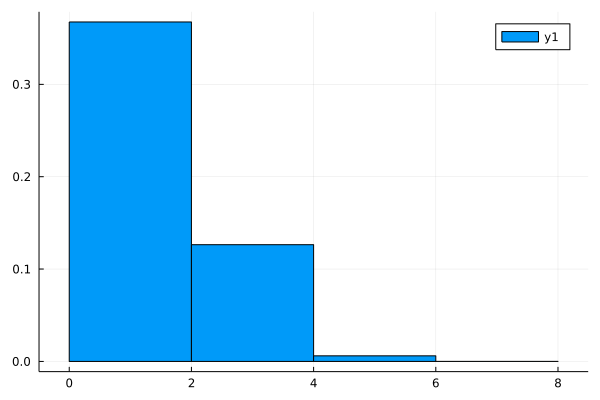

In [279]:
Nt=10#,100,1000
pt=1/10#, 1/3, 1/2, 2/3,9/10
d=Binomial(Nt, pt)
histogram(rand(d,100000),normalize=:true,bins=6)

In [43]:
JOLIS=[[0,10],[0,100],[50,100]]

3-element Vector{Vector{Int64}}:
 [0, 10]
 [0, 100]
 [50, 100]

In [24]:
length(LOICS)

3

In [75]:
mkpath("./HOLI/HE")

"./HOLI/HE"

In [105]:
N,M=2,3

(2, 3)

In [11]:
[2 0 0; 1 1 0]*4

2×3 Matrix{Int64}:
 8  0  0
 4  4  0

In [16]:
N0=7
M0=6
D=binomial(N0+M0-1,N0)

792

In [41]:
for i=1:10
    for j=1:3
        i%2==0 ? continue : nothing
        println(i)
    end
end

1
1
1
3
3
3
5
5
5
7
7
7
9
9
9


In [43]:
? nothing

search: nothing Nothing isnothing



```
nothing
```

The singleton instance of type [`Nothing`](@ref), used by convention when there is no value to return (as in a C `void` function) or when a variable or field holds no value.

See also: [`isnothing`](@ref), [`something`](@ref), [`missing`](@ref).
